In [ ]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import array
from numpy import hstack
import gc
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import pywt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import GlobalAveragePooling1D

In [ ]:
# Importing dataset
df_origin = pd.read_csv('measures_v2.csv')

In [ ]:
df_original = df_origin.copy()

In [ ]:
df_original["i_s"] = np.sqrt(df_original.i_d**2+df_original.i_q**2)
df_original["u_s"] = np.sqrt(df_original.u_d**2+df_original.u_q**2)
df_original["s_el"] = 1.5*df_original.i_s*df_original.u_s

df_original["iu_s"] = (df_original.i_s*df_original.u_s)
df_original["is_sel"] = (df_original.i_s*df_original.s_el)
df_original["us_sel"] = (df_original.u_s*df_original.s_el)

In [ ]:
df_original.head()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id,i_s,u_s,s_el,iu_s,is_sel,us_sel
0,-0.450682,18.805172,19.086670,-0.350055,18.293219,0.002866,0.004419,0.000328,24.554214,18.316547,19.850691,0.187101,17,0.004431,0.570659,0.003793,0.002529,1.680856e-05,0.002165
1,-0.325737,18.818571,19.092390,-0.305803,18.294807,0.000257,0.000606,-0.000785,24.538078,18.314955,19.850672,0.245417,17,0.000992,0.446789,0.000665,0.000443,6.593663e-07,0.000297
2,-0.440864,18.828770,19.089380,-0.372503,18.294094,0.002355,0.001290,0.000386,24.544693,18.326307,19.850657,0.176615,17,0.001346,0.577165,0.001166,0.000777,1.569074e-06,0.000673
3,-0.327026,18.835567,19.083031,-0.316199,18.292542,0.006105,0.000026,0.002046,24.554018,18.330833,19.850647,0.238303,17,0.002046,0.454893,0.001396,0.000931,2.855851e-06,0.000635
4,-0.471150,18.857033,19.082525,-0.332272,18.291428,0.003133,-0.064317,0.037184,24.565397,18.326662,19.850639,0.208197,17,0.074292,0.576530,0.064247,0.042832,4.773050e-03,0.037041


In [ ]:
cols = df_original.columns.to_list()
target_cols = ['stator_tooth', 'stator_winding', 'stator_yoke', 'pm']
input_cols = [col for col in cols if col not in target_cols]
input_cols.remove('profile_id')
cols =  input_cols + target_cols + ['profile_id']
df_original = df_original[cols]
n_features = len(input_cols)
df_original.head()

,u_q,coolant,u_d,motor_speed,i_d,i_q,ambient,torque,i_s,u_s,s_el,iu_s,is_sel,us_sel,stator_tooth,stator_winding,stator_yoke,pm,profile_id
0,-0.450682,18.805172,-0.350055,0.002866,0.004419,0.000328,19.850691,0.187101,0.004431,0.570659,0.003793,0.002529,1.680856e-05,0.002165,18.293219,19.086670,18.316547,24.554214,17
1,-0.325737,18.818571,-0.305803,0.000257,0.000606,-0.000785,19.850672,0.245417,0.000992,0.446789,0.000665,0.000443,6.593663e-07,0.000297,18.294807,19.092390,18.314955,24.538078,17
2,-0.440864,18.828770,-0.372503,0.002355,0.001290,0.000386,19.850657,0.176615,0.001346,0.577165,0.001166,0.000777,1.569074e-06,0.000673,18.294094,19.089380,18.326307,24.544693,17
3,-0.327026,18.835567,-0.316199,0.006105,0.000026,0.002046,19.850647,0.238303,0.002046,0.454893,0.001396,0.000931,2.855851e-06,0.000635,18.292542,19.083031,18.330833,24.554018,17
4,-0.471150,18.857033,-0.332272,0.003133,-0.064317,0.037184,19.850639,0.208197,0.074292,0.576530,0.064247,0.042832,4.773050e-03,0.037041,18.291428,19.082525,18.326662,24.565397,17


In [ ]:
zero_padding = 10000
chunks = []

for pid in df_original.profile_id.unique():
  prof_df = df_original[df_original['profile_id'] == pid]
  profile_first_index = prof_df.index[0]
  profile_last_index = prof_df.index[-1]
  zeros = np.zeros((zero_padding, df_original.shape[1]))
  zeros[:, -1] = pid
  chunks.append(zeros)
  chunks.append(prof_df)

zero_padded_df = pd.DataFrame(np.vstack(chunks), columns=df_original.columns)

In [ ]:
zero_padded_df.head()

,u_q,coolant,u_d,motor_speed,i_d,i_q,ambient,torque,i_s,u_s,s_el,iu_s,is_sel,us_sel,stator_tooth,stator_winding,stator_yoke,pm,profile_id
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0


In [ ]:
ewma_spans = [500, 2200, 6000, 9000]
ewmstd_spans = [500, 2200, 6000, 9000]
ma_spans = []
f_dfs = []
for span in ewma_spans:
  f_dfs.append(zero_padded_df.ewm(span=span).mean()[input_cols].add_prefix(f'ewma{span}_'))

for span in ewmstd_spans:
  f_dfs.append(zero_padded_df.ewm(span=span).std()[input_cols].add_prefix(f'ewmstd{span}_'))

for span in ma_spans:
  f_dfs.append(zero_padded_df.rolling(span,1).mean()[input_cols].add_prefix(f'ma{span}_'))

f_dfs.append(zero_padded_df)
fdf = pd.concat(f_dfs, axis=1)

del f_dfs
gc.collect()

8

In [ ]:
fdf.drop(fdf[fdf['pm'] == 0].index, axis=0, inplace=True)

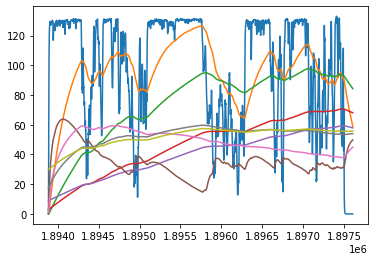

In [ ]:
profile = fdf[fdf['profile_id'] == 52]

plt.plot(profile['u_s'])
for span in ewma_spans:
  plt.plot(profile[f'ewma{span}_u_s'])
for span in ewmstd_spans:
  plt.plot(profile[f'ewmstd{span}_u_s'])
for span in ma_spans:
  plt.plot(profile[f'ma{span}_u_s'])

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

def preprocess_series(data, train=False):
  if train:
    scaler.fit(data)
  
  return scaler.transform(data)
  
def invTransform(data):
    # return data
    dummy = np.zeros((len(data), scaler.n_features_in_))
    dummy[:, -4:] = data
    return scaler.inverse_transform(dummy)[:, -4:]
    

In [ ]:
train_data = fdf[~fdf.profile_id.isin([65, 72, 58])].drop(columns=['profile_id']).to_numpy()
val_data = fdf[fdf.profile_id.isin([58])].drop(columns=['profile_id']).to_numpy()
test1_data = fdf[fdf.profile_id.isin([65])].drop(columns=['profile_id']).to_numpy()
test2_data = fdf[fdf.profile_id.isin([72])].drop(columns=['profile_id']).to_numpy()

In [ ]:
train_data = preprocess_series(train_data, train=True)
val_data = preprocess_series(val_data, train=False)
test1_data = preprocess_series(test1_data, train=False)
test2_data = preprocess_series(test2_data, train=False)

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator

n_steps = 128
batch_size = 1024

train_generator = TimeseriesGenerator(train_data[:, :-4], train_data[:, -4:], length=n_steps, batch_size=batch_size, shuffle=True)
val_generator = TimeseriesGenerator(val_data[:, :-4], val_data[:, -4:], length=n_steps, batch_size=batch_size)
test1_generator = TimeseriesGenerator(test1_data[:, :-4], test1_data[:, -4:], length=n_steps, batch_size=batch_size)
test2_generator = TimeseriesGenerator(test2_data[:, :-4], test2_data[:, -4:], length=n_steps, batch_size=batch_size)


In [ ]:
train_data.shape

(1242039, 130)

In [ ]:

n_features = train_data.shape[1] - 4
# define model

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=7, activation='relu', input_shape=(n_steps, n_features)))
model.add(Conv1D(filters=64, kernel_size=7, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(4))
model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 122, 64)           56512     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 116, 64)           28736     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 58, 64)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3712)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                118816    
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 132       
Total params: 204,196
Trainable params: 204,196
Non-trainable params: 0
________________________________________________

In [ ]:
# fit model

callbacks = [tf.keras.callbacks.ModelCheckpoint('transfer_learning_weights.h5',monitor='val_acc',save_best_only=True),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode = 'min'), 
             tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", mode = "min", patience=5)]

history = model.fit(train_generator, validation_data=val_generator, batch_size = batch_size , epochs=50, verbose=1, callbacks = callbacks)


Epoch 1/50
1213/1213 [==============================] - 557s 459ms/step - loss: 0.0233 - mse: 0.0233 - mae: 0.0690 - val_loss: 0.0219 - val_mse: 0.0219 - val_mae: 0.1137
Epoch 2/50
1213/1213 [==============================] - 561s 462ms/step - loss: 0.0028 - mse: 0.0028 - mae: 0.0345 - val_loss: 0.0168 - val_mse: 0.0168 - val_mae: 0.0984
Epoch 3/50
1213/1213 [==============================] - 559s 461ms/step - loss: 0.0022 - mse: 0.0022 - mae: 0.0307 - val_loss: 0.0134 - val_mse: 0.0134 - val_mae: 0.0893
Epoch 4/50
1213/1213 [==============================] - 556s 458ms/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0286 - val_loss: 0.0124 - val_mse: 0.0124 - val_mae: 0.0871
Epoch 5/50
1213/1213 [==============================] - 559s 460ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0279 - val_loss: 0.0103 - val_mse: 0.0103 - val_mae: 0.0703
Epoch 6/50
1213/1213 [==============================] - 556s 459ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0260 - val_loss: 0.0103 - val_mse: 0.010

In [ ]:
# Saving model and History
model.save('cnn_m.h5')

import pickle
with open('cnn_h.pkl', 'wb+') as h:
 	pickle.dump(history.history,h)


In [ ]:

# Loading Model and History
from keras.models import load_model
model = load_model('cnn_m.h5')

import pickle
with open('cnn_h.pkl', 'rb') as h:
	history = pickle.load(h)

In [ ]:
y_test1 = invTransform(test1_generator.targets)[128:]
y_test2 = invTransform(test2_generator.targets)[128:]
y_val = invTransform(val_generator.targets)[128:]

In [ ]:
test1_pred = invTransform(model.predict(test1_generator))
test2_pred = invTransform(model.predict(test2_generator))
val_pred = invTransform(model.predict(val_generator))

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

for t, tn in enumerate(target_cols):
    test1_mse = mean_squared_error(y_test1[:,t], test1_pred[:,t])
    test1_mae = mean_absolute_error(y_test1[:,t], test1_pred[:,t])
    test1_r2 = r2_score(y_test1[:,t], test1_pred[:,t])
    test2_mse = mean_squared_error(y_test2[:,t], test2_pred[:,t])
    test2_mae = mean_absolute_error(y_test2[:,t], test2_pred[:,t])
    test2_r2 = r2_score(y_test2[:,t], test2_pred[:,t])
    val_mse = mean_squared_error(y_val[:,t], val_pred[:,t])
    val_mae = mean_absolute_error(y_val[:,t], val_pred[:,t])
    val_r2 = r2_score(y_val[:,t], val_pred[:,t])
    print(f'=== {tn} ===\n')
    print(f'(Test) Profile 65: {test1_mse}\t{test1_mae}\t{test1_r2}\n')
    print(f'(Test) Profile 72: {test2_mse}\t{test2_mae}\t{test2_r2}\n')
    print(f'(Val)  Profile 58: {val_mse}\t{val_mae}\t{val_r2}\n')


=== stator_tooth ===

(Test) Profile 65: 2.2190997712471416	1.072896633893078	0.9950983731287981

(Test) Profile 72: 1.0699121133921738	0.8366300053814459	0.9974608433911379

(Val)  Profile 58: 3.315768834532484	1.4608733609735647	0.9874939556221004

=== stator_winding ===

(Test) Profile 65: 3.349281864094229	1.4048221685198778	0.9954148079078123

(Test) Profile 72: 1.6482470533238243	1.0201744688808974	0.9966770439146312

(Val)  Profile 58: 4.855853435432458	1.7911124140267907	0.9884264604382793

=== stator_yoke ===

(Test) Profile 65: 1.5273940380367212	0.9101701529801766	0.9948622491339748

(Test) Profile 72: 1.0121019353193128	0.8101597949278979	0.997622452789724

(Val)  Profile 58: 1.6718686993657759	1.033138551839261	0.9936628341909747

=== pm ===

(Test) Profile 65: 3.507645778678209	1.5755274400800472	0.9846220467707242

(Test) Profile 72: 7.0111057691863605	1.6133746717123734	0.9197183166589395

(Val)  Profile 58: 7.586313115747162	1.961702281973661	0.9286953005229424



In [ ]:

print(history.history.keys())

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae', 'lr'])


In [ ]:
history.keys()

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae', 'lr'])

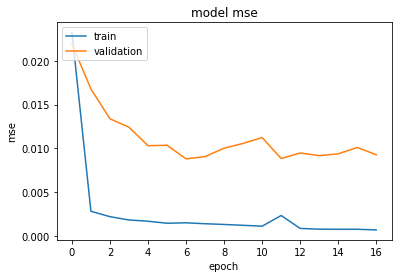

In [ ]:
# summarize history for mse
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'validation']#, loc='upper left')
plt.show()

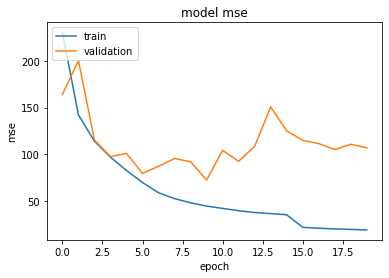

In [ ]:


# summarize history for mse
plt.plot(history['mse'])
plt.plot(history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
model.evaluate(test_x, test_y)

862/862 [==============================] - 2s 2ms/step - loss: 108.1094 - mse: 108.1094 - mae: 7.5661


[108.10940551757812, 108.10940551757812, 7.566065311431885]

In [ ]:
model.evaluate(prof65_x, prof65_y)

623/623 [==============================] - 1s 2ms/step - loss: 104.9525 - mse: 104.9525 - mae: 7.4387


[104.95246124267578, 104.95246124267578, 7.43873405456543]

In [ ]:
model.evaluate(prof72_x, prof72_y)

236/236 [==============================] - 1s 2ms/step - loss: 102.3774 - mse: 102.3774 - mae: 7.6038


[102.37740325927734, 102.37740325927734, 7.603786468505859]

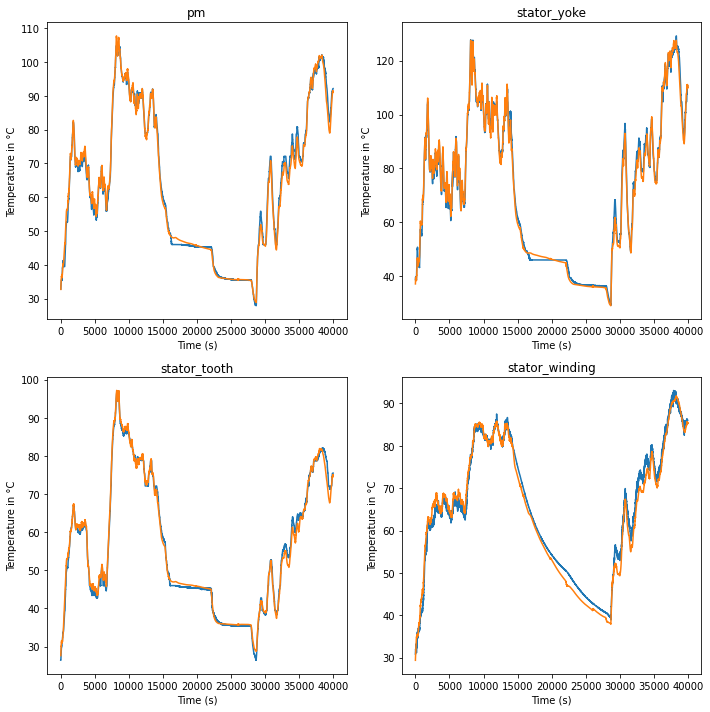

In [ ]:
title_list = ['pm','stator_yoke','stator_tooth','stator_winding']

fig, ax = plt.subplots(2,2)

for i, (title,a) in enumerate(zip(title_list, ax.flatten())):
    a.set_title(title)
    a.plot(y_test1[:,i])
    a.plot(test1_pred[:,i])
    a.set_ylabel('Temperature in °C')
    a.set_xlabel('Time (s)') 
                              

fig.set_size_inches(10,10)
fig.tight_layout()

fig.savefig('prof65.pdf')


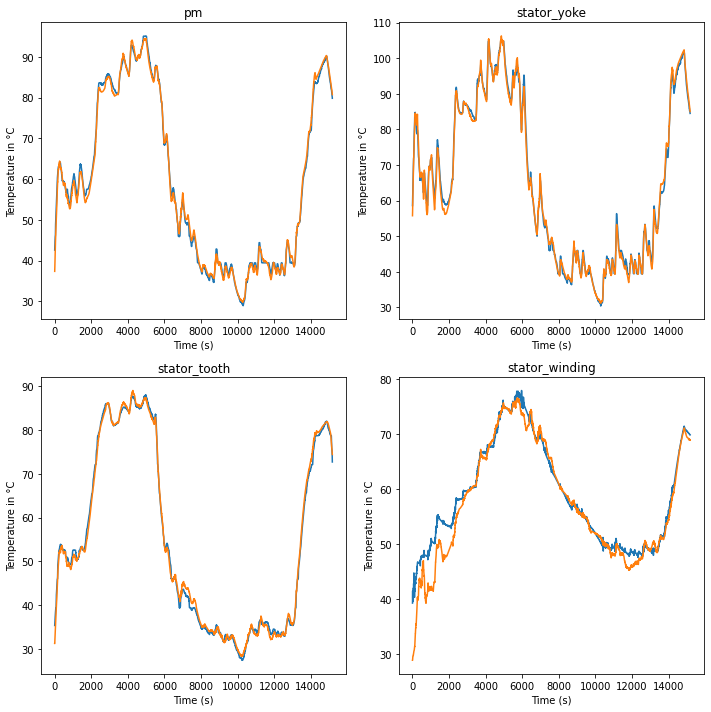

In [ ]:
title_list = ['pm','stator_yoke','stator_tooth','stator_winding']

fig, ax = plt.subplots(2,2)

for i, (title,a) in enumerate(zip(title_list, ax.flatten())):
    a.set_title(title)
    a.plot(y_test2[:,i])
    a.plot(test2_pred[:,i])
    a.set_ylabel('Temperature in °C')
    a.set_xlabel('Time (s)') 
                              

fig.set_size_inches(10, 10)
fig.tight_layout()

fig.savefig('prof72.pdf')

In [ ]:
def plot_predictions(y_true, y_pred, name):
    title_list = ['$\\theta_{ST}$','$\\theta_{SW}$','$\\theta_{SY}$','$\\theta_{PM}$']

    fig, ax = plt.subplots(2,4, sharey='row', sharex=True)
    ax[0,0].set_ylabel('Measured and\nestimated\ntemp. in °C')
    ax[1,0].set_ylabel('Temperature\nestimation\nerror in °C')
    xticks = np.arange(np.ceil(len(y_true)/7200)).astype(int)

    for i, a in enumerate(ax[0]):
        a.grid()
        a.set_title(title_list[i])
        a.plot(y_true[:,i], color='orange')
        a.plot(y_pred[:,i], color='blue')

    for i, a in enumerate(ax[1]):
        a.grid()
        a.set_xlabel('Time (h)')
        a.plot(y_true[:,i]-y_pred[:,i], color='red')
        a.set_xticks(xticks*7200)
        a.set_xticklabels(xticks)
                              

    fig.set_size_inches(9.5,3.5)
    fig.tight_layout()
    fig.legend(['Actual', 'Predicted'], loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.07))

    fig.savefig(f'{name}.pdf', bbox_inches = "tight")


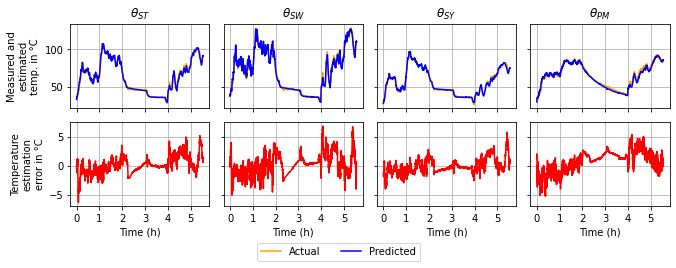

In [ ]:
plot_predictions(y_test1, test1_pred, "prof65_ewma")

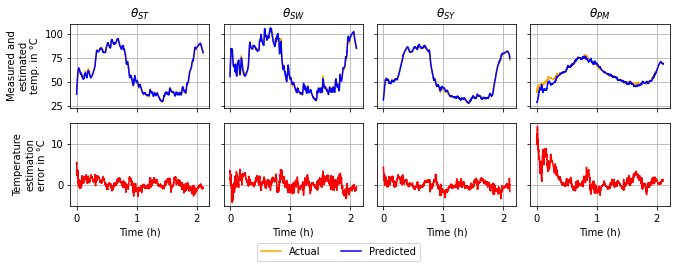

In [ ]:
plot_predictions(y_test2, test2_pred, "prof72_ewma")